У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
# Завантаження даних
df = pd.read_csv("train.csv")

In [3]:
# Перетворення колонки 'date' на формат datetime
df['date'] = pd.to_datetime(df['date'])

# Встановлення колонки 'date' як індексу
df.set_index('date', inplace=True)

In [4]:
# Виведення перших 10 рядків
df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [5]:
# Виведення інформації про датафрейм
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [6]:
df.dtypes

,0
store,int64
item,int64
sales,int64


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


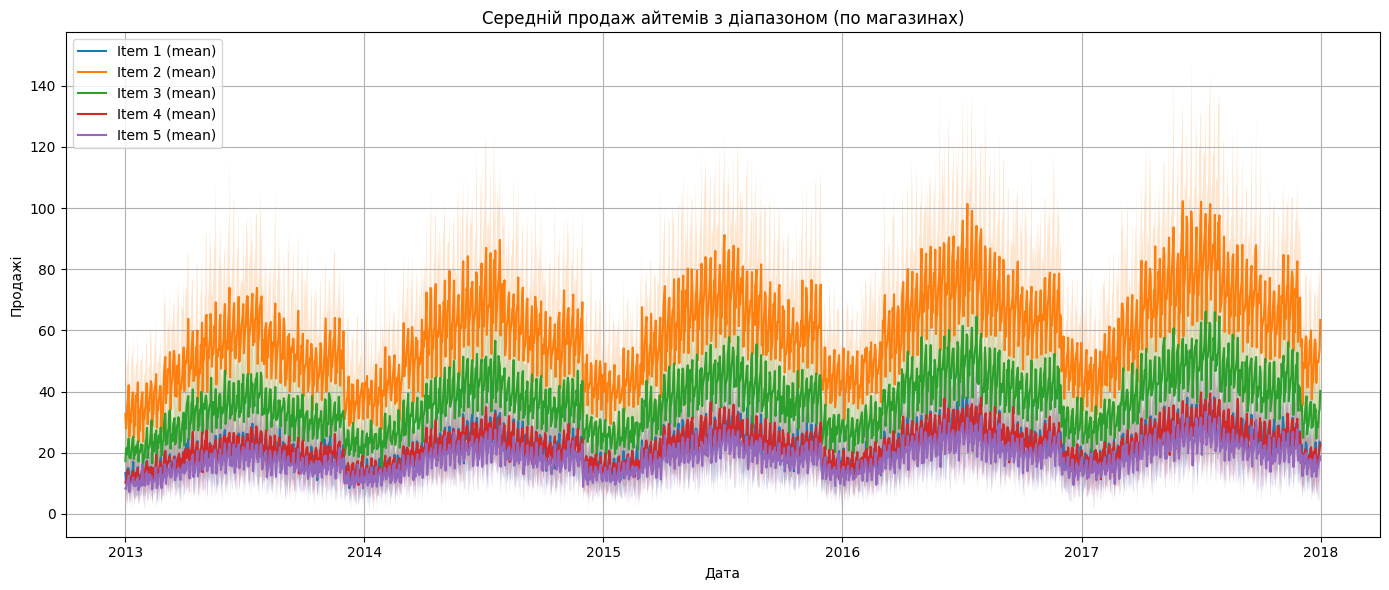

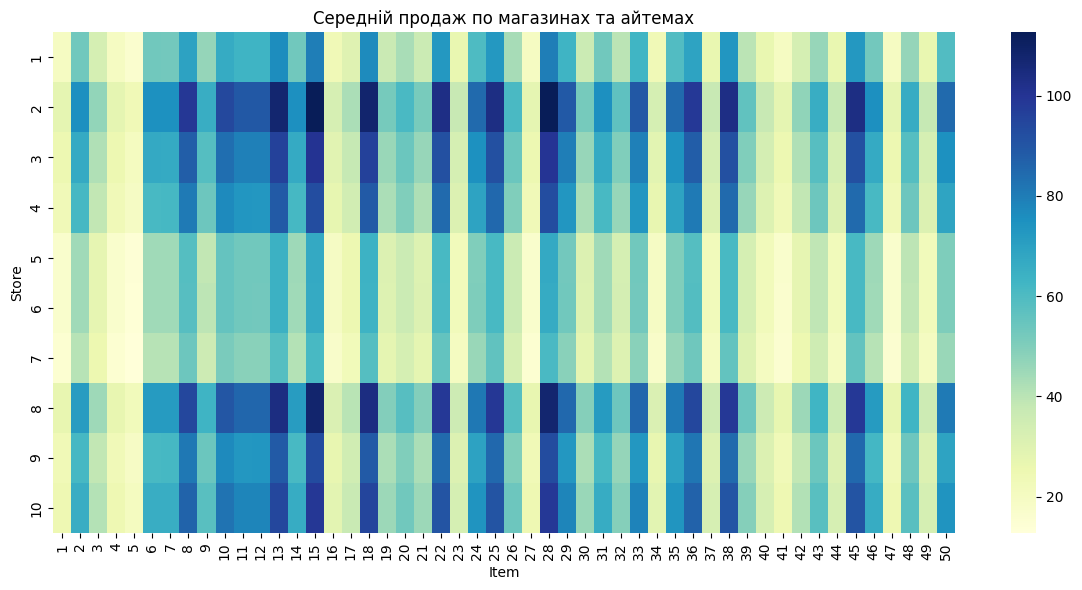

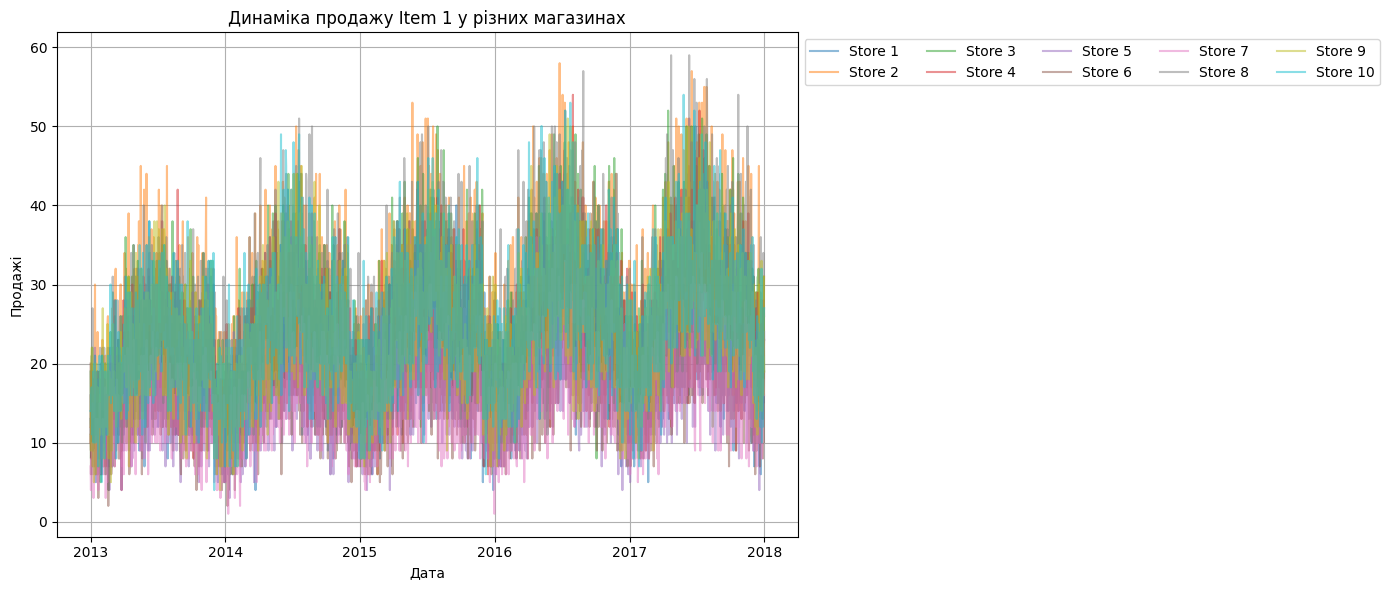

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Графік 1: Середній продаж айтемів з мін-макс діапазоном по магазинах
plt.figure(figsize=(14, 6))
sample_items = df['item'].unique()[:5]  # Наприклад, перші 5 айтемів
for item_id in sample_items:
    item_df = df[df['item'] == item_id]
    daily_grouped = item_df.groupby(item_df.index).agg({'sales': ['mean', 'min', 'max']})
    daily_grouped.columns = ['mean', 'min', 'max']
    plt.plot(daily_grouped.index, daily_grouped['mean'], label=f'Item {item_id} (mean)')
    plt.fill_between(
        daily_grouped.index,
        daily_grouped['min'],
        daily_grouped['max'],
        alpha=0.2
    )
plt.title('Середній продаж айтемів з діапазоном (по магазинах)')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Графік 2: Теплова карта середніх продажів по магазинах та айтемах
pivot_table = df.groupby(['store', 'item'])['sales'].mean().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Середній продаж по магазинах та айтемах')
plt.xlabel('Item')
plt.ylabel('Store')
plt.tight_layout()
plt.show()

# Графік 3: Динаміка одного айтема по всіх магазинах
plt.figure(figsize=(14, 6))
item_to_plot = 1
subset = df[df['item'] == item_to_plot]
for store_id in subset['store'].unique():
    store_df = subset[subset['store'] == store_id]
    daily_sales = store_df.groupby(store_df.index)['sales'].sum()
    plt.plot(daily_sales.index, daily_sales.values, alpha=0.5, label=f'Store {store_id}')
plt.title(f'Динаміка продажу Item {item_to_plot} у різних магазинах')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend(ncol=5, bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

- Продажі дійсно відрізняються як по айтемах, так і по магазинах. В деяких магазинах один і той самий айтем має стабільні продажі, в інших - спостерігаються значні коливання.
- Видно сезонність у багатьох рядах: циклічні підйоми і спади.
- Є аномальні піки - можливо, акції або святкові періоди.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

<Figure size 1200x1000 with 0 Axes>

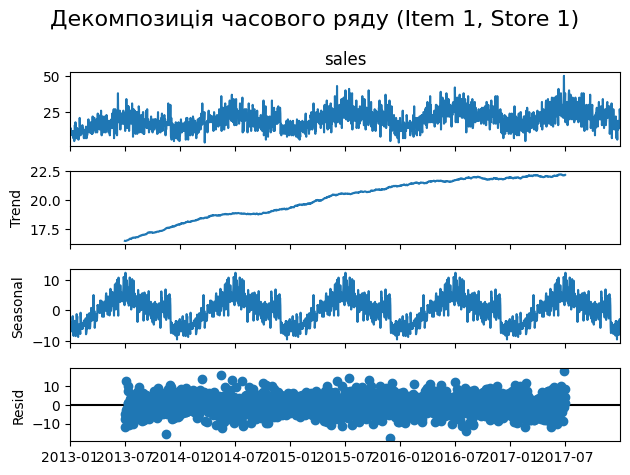

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Вибір підмножини даних для item 1 у store 1
subset = df[(df['store'] == 1) & (df['item'] == 1)]
subset = subset.groupby(subset.index)['sales'].sum()  # агрегуємо по даті
subset = subset.asfreq('D')  # забезпечуємо щоденну частоту з пропущеними значеннями як NaN

# Декомпозиція за адитивною моделлю
result = seasonal_decompose(subset, model='additive', period=365)

# Візуалізація результатів
plt.figure(figsize=(12, 10))
result.plot()
plt.suptitle('Декомпозиція часового ряду (Item 1, Store 1)', fontsize=16)
plt.tight_layout()
plt.show()

- Чітко видно тренд - поступове зростання обсягів продажів.
- Сезонна складова вказує на повторювану структуру - можливо, тижневу або місячну.
- Залишки виглядають як випадкові шуми, без вираженої структури, але з деякими сплесками - це можуть бути аномалії.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [10]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
from darts import TimeSeries

subset = subset.asfreq('D')
subset = subset.fillna(0)
series = TimeSeries.from_series(subset)

# Перевірка
print(series)

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U5 20B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

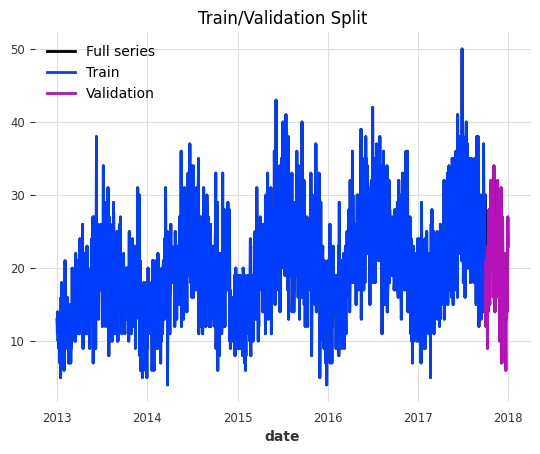

In [12]:
train, val = series.split_before(pd.Timestamp('2017-10-01'))

series.plot(label='Full series')
train.plot(label='Train')
val.plot(label='Validation')
plt.legend()
plt.title("Train/Validation Split")
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

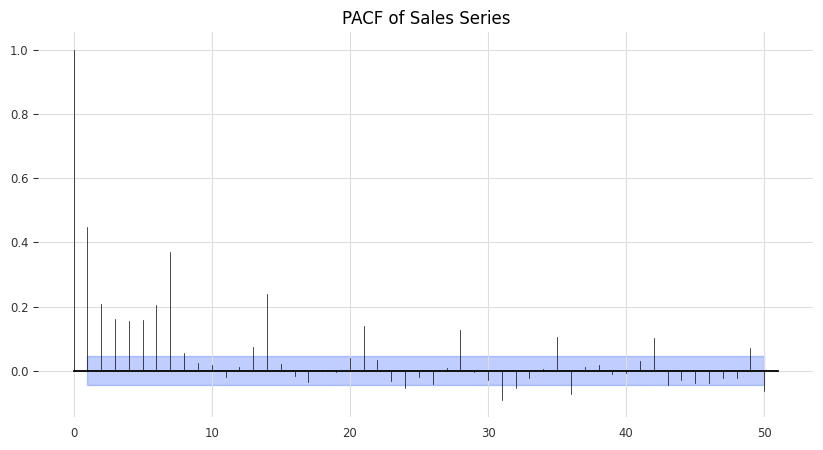

In [14]:
from darts.utils.statistics import plot_pacf

plot_pacf(series, max_lag=50)
plt.title("PACF of Sales Series")
plt.show()

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [16]:
from darts.utils.statistics import check_seasonality

check_seasonality(train, max_lag=365, alpha=0.05)

(True, np.int64(7))

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [40]:
# Тестування моделі NaiveSeasonal з сезонністю 7 (за результатами check_seasonality)
seasonal_model = NaiveSeasonal(K=7)  # використовуємо K=7 для тижневих сезонів
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(forecast_horizon)

# Drift модель залишаємо без змін
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(forecast_horizon)

# Модифікуємо середнє прогнозу (додаємо ваги)
ensemble_forecast = 0.75 * seasonal_forecast + 0.25 * drift_forecast


MAPE на валідації: 42.29%


9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [41]:

# Визначення MAPE для валідації
from darts.metrics import mape
error = mape(val, ensemble_forecast)
print(f"MAPE на валідації: {error:.2f}%")

MAPE на валідації: 42.29%


Результат зовсім поганий, дуже велика помилка

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

MAPE на валідації: 36.90%


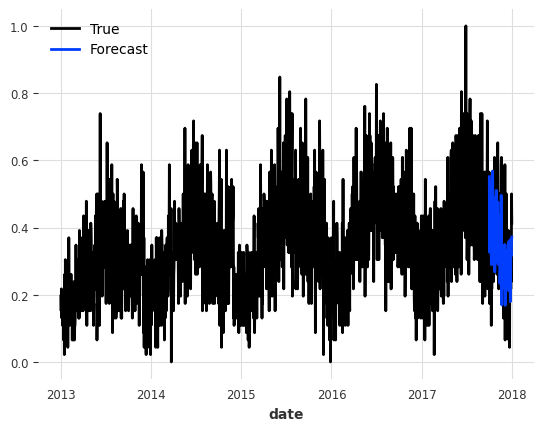

In [44]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape

# Масштабуємо series окремо
scaler_series = Scaler()
series_scaled = scaler_series.fit_transform(series)

# Створюємо ознаки з дати (включаємо більше атрибутів)
covariates = covariates.stack(datetime_attribute_timeseries(series, "week", one_hot=True)) \
                    .stack(datetime_attribute_timeseries(series, "month", one_hot=True)) \
                    .stack(datetime_attribute_timeseries(series, "dayofweek", one_hot=True)) \
                    .stack(datetime_attribute_timeseries(series, "quarter", one_hot=True))

# Масштабуємо covariates окремо
scaler_cov = Scaler()
covariates_scaled = scaler_cov.fit_transform(covariates)

# Розділяємо на тренування та валідацію
train_series, val_series = series_scaled.split_before(pd.Timestamp("2017-10-01"))
train_cov, val_cov = covariates_scaled.split_before(pd.Timestamp("2017-10-01"))

# Створюємо та тренуємо модель з іншими параметрами
model = XGBModel(lags=14, lags_future_covariates=[0], output_chunk_length=len(val_series), random_state=42,
                 n_estimators=100, learning_rate=0.05, max_depth=6, min_child_weight=1)
model.fit(train_series, future_covariates=train_cov)

# Прогнозуємо
forecast = model.predict(len(val_series), future_covariates=val_cov)

# Візуалізація
series_scaled.plot(label="True")
forecast.plot(label="Forecast")

# Оцінка
error = mape(val_series, forecast)
print(f"MAPE на валідації: {error:.2f}%")

In [46]:
from darts.models import XGBModel
from darts.metrics import mape

# Перебір гіперпараметрів вручну
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

best_mape = float('inf')
best_params = {}

# Ітерація по гіперпараметрах
for lr in param_grid['learning_rate']:
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for subsample in param_grid['subsample']:
                for colsample in param_grid['colsample_bytree']:
                    # Створення моделі
                    model = XGBModel(
                        lags=14,
                        lags_future_covariates=[0],
                        output_chunk_length=len(val_series),
                        random_state=42,
                        learning_rate=lr,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        subsample=subsample,
                        colsample_bytree=colsample
                    )
                    model.fit(train_series, future_covariates=train_cov)
                    forecast = model.predict(len(val_series), future_covariates=val_cov)

                    # Оцінка помилки
                    error = mape(val_series, forecast)
                    print(f"Params: lr={lr}, n_estimators={n_estimators}, max_depth={max_depth}, "
                          f"subsample={subsample}, colsample={colsample} => MAPE: {error:.2f}%")

                    # Збереження кращих параметрів
                    if error < best_mape:
                        best_mape = error
                        best_params = {
                            'learning_rate': lr,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'subsample': subsample,
                            'colsample_bytree': colsample
                        }

print(f"Best parameters: {best_params}")

Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.7, colsample=0.7 => MAPE: 41.10%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.7, colsample=0.8 => MAPE: 41.09%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.7, colsample=0.9 => MAPE: 41.08%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.8, colsample=0.7 => MAPE: 41.00%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.8, colsample=0.8 => MAPE: 40.96%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.8, colsample=0.9 => MAPE: 40.96%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.9, colsample=0.7 => MAPE: 41.11%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.9, colsample=0.8 => MAPE: 40.96%
Params: lr=0.01, n_estimators=50, max_depth=3, subsample=0.9, colsample=0.9 => MAPE: 40.94%
Params: lr=0.01, n_estimators=50, max_depth=6, subsample=0.7, colsample=0.7 => MAPE: 40.60%
Params: lr=0.01, n_estimators=50, max_depth=6, subsample=0.7, colsample=0.8 => M

KeyboardInterrupt: 

Зупинила пошук. зі знайдених найкращі параметри: Params: lr=0.01, n_estimators=200, max_depth=6, subsample=0.9, colsample=0.7 => MAPE: 36.04%

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

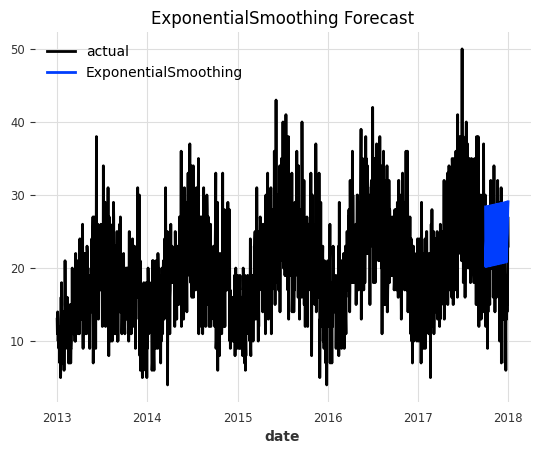

ExponentialSmoothing MAPE: 39.01284109999829


In [25]:
from darts.models import ExponentialSmoothing

model_es = ExponentialSmoothing()
model_es.fit(train)
forecast_es = model_es.predict(len(val))

series.plot(label="actual")
forecast_es.plot(label="ExponentialSmoothing")
plt.legend()
plt.title("ExponentialSmoothing Forecast")
plt.show()

print("ExponentialSmoothing MAPE:", mape(val, forecast_es))

Також велика помилка

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


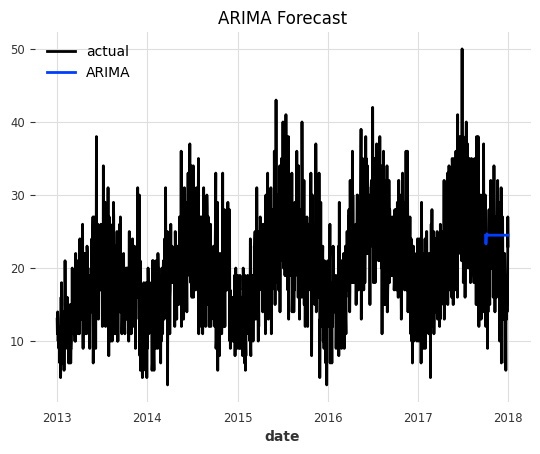

ARIMA MAPE: 40.63708480412378


In [26]:
from darts.models import ARIMA

model_arima = ARIMA(p=3, d=1, q=2)
model_arima.fit(train)
forecast_arima = model_arima.predict(len(val))

series.plot(label="actual")
forecast_arima.plot(label="ARIMA")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

print("ARIMA MAPE:", mape(val, forecast_arima))

Досить велика помилка

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

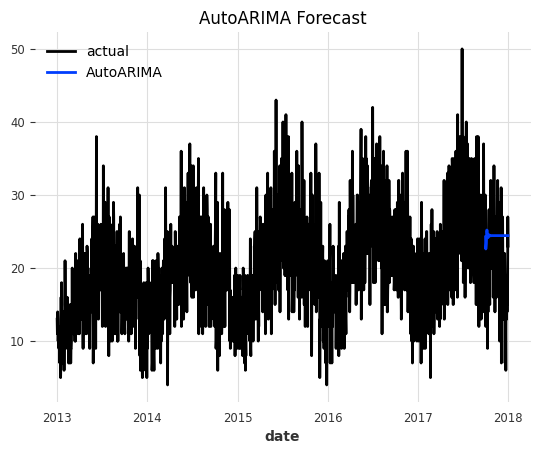

AutoARIMA MAPE: 40.294072271660795


In [27]:
from darts.models import AutoARIMA

model_auto_arima = AutoARIMA()
model_auto_arima.fit(train)
forecast_auto_arima = model_auto_arima.predict(len(val))

series.plot(label="actual")
forecast_auto_arima.plot(label="AutoARIMA")
plt.legend()
plt.title("AutoARIMA Forecast")
plt.show()

print("AutoARIMA MAPE:", mape(val, forecast_auto_arima))

Досить велика помилка

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8vng3c_y/svul5h__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8vng3c_y/yy7lbx4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47230', 'data', 'file=/tmp/tmp8vng3c_y/svul5h__.json', 'init=/tmp/tmp8vng3c_y/yy7lbx4e.json', 'output', 'file=/tmp/tmp8vng3c_y/prophet_modelmpcocv1y/prophet_model-20250507111705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:17:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:17:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


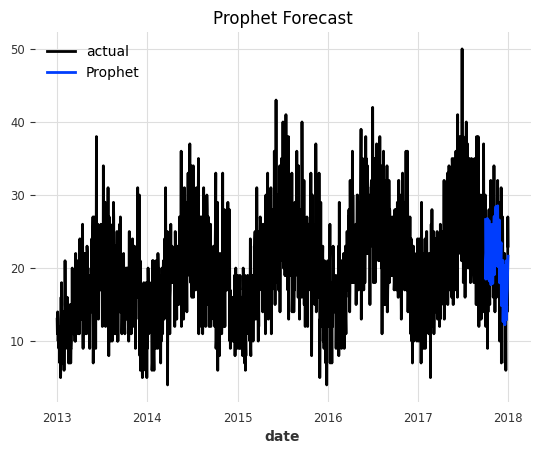

Prophet MAPE: 23.80480380321674


In [47]:
from darts.models import Prophet

model_prophet = Prophet()
model_prophet.fit(train)
forecast_prophet = model_prophet.predict(len(val))

series.plot(label="actual")
forecast_prophet.plot(label="Prophet")
plt.legend()
plt.title("Prophet Forecast")
plt.show()

print("Prophet MAPE:", mape(val, forecast_prophet))

Найкраща зі зроблених, але помилка, все одно, досить велика.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 12.6 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

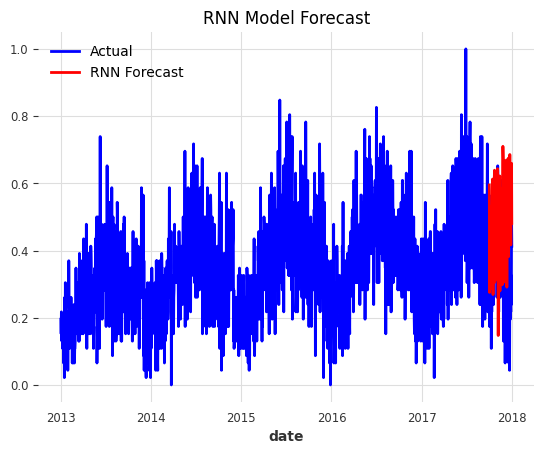

MAPE для RNN: 74.11%


In [52]:
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import mape

# Масштабуємо серію
scaler_series = Scaler()
series_scaled = scaler_series.fit_transform(series)

# Розділяємо на тренувальний та валідаційний набори
train_series, val_series = series_scaled.split_before(pd.Timestamp("2017-10-01"))

# Створюємо та тренуємо модель RNN без training_epochs і з фіксованим output_chunk_length=1
model_rnn = RNNModel(
    input_chunk_length=24,  # Вхідний шматок (часовий інтервал)
    output_chunk_length=1,  # Фіксоване значення для RNN
    hidden_dim=64,  # Кількість нейронів у кожному шарі
    n_rnn_layers=2,  # Кількість шарів
    random_state=42
)

model_rnn.fit(train_series)

# Прогнозуємо на валідаційному наборі
forecast_rnn = model_rnn.predict(len(val_series))

# Візуалізація результатів
series_scaled.plot(label="Actual", color='blue')
forecast_rnn.plot(label="RNN Forecast", color='red')
plt.legend()
plt.title("RNN Model Forecast")
plt.show()

# Оцінка помилки
error_rnn = mape(val_series, forecast_rnn)
print(f"MAPE для RNN: {error_rnn:.2f}%")

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8vng3c_y/gtkp3_dy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8vng3c_y/5y_xsyco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23411', 'data', 'file=/tmp/tmp8vng3c_y/gtkp3_dy.json', 'init=/tmp/tmp8vng3c_y/5y_xsyco.json', 'output', 'file=/tmp/tmp8vng3c_y/prophet_modelnx4hu14t/prophet_model-20250507111847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   8%|▊         | 1/12 [00:00<00:06,  1.82it/s]INFO:prophet:D

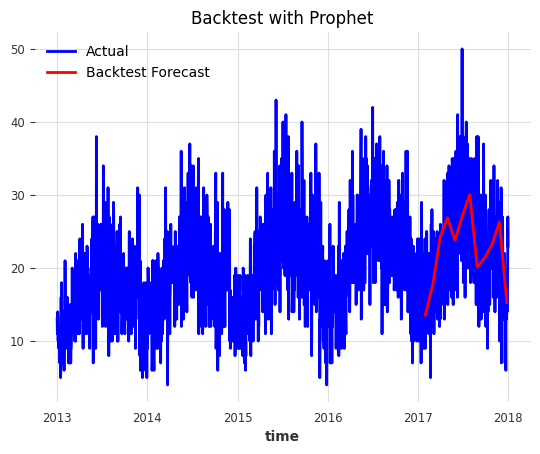

Backtest MAPE: 24.490479568804393


In [50]:
from darts.models import Prophet
import matplotlib.pyplot as plt
from darts.metrics import mape

# Виконуємо бектест
backtest = model_prophet.historical_forecasts(
    series,
    start=pd.Timestamp("2017-01-01"),  # Початок бектесту
    forecast_horizon=30,  # Прогнозуємо на 30 днів вперед
    stride=30,  # Кожні 30 днів будуємо новий прогноз
    retrain=True,  # Переобучаємо модель на кожному кроці
    verbose=True  # Виводимо інформацію
)

# Візуалізація результатів
series.plot(label="Actual", color='blue')
backtest.plot(label="Backtest Forecast", color='red')

plt.legend()
plt.title("Backtest with Prophet")
plt.show()

# Оцінка помилки на бектесті
error = mape(series.slice_intersect(backtest), backtest)
print("Backtest MAPE:", error)

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Я б сформувала функцію, яка для кожної пари (store, item) створює TimeSeries і тренує модель (наприклад, XGB або ExponentialSmoothing).
Це можна робити в циклі або за допомогою паралельної обробки.

Модель:
Потрібно ще експериментувати
- Враховувала би сезонність, свята, лаги, коверіати.

Скільки моделей?
- окрема модель на кожну пару (50 айтемів × 10 магазинів = 500 моделей).